# Forming Queries: PostGIS Functions

PostGIS offer a host of functions that we can access through python using special functions to utilize them 

Don't forget your [cheat sheets](https://snowexsql.readthedocs.io/en/latest/cheat_sheet.html)! 


In general they follow the convention
``` sql
ST_<Function_Name>
```

They also tend to fall into (generally) 2 categories, points and rasters. 


## Process 
### Get Connected

In [1]:
# Import the function to get connect to the db
from snowexsql.db import get_db

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@db.snowexdata.org/snowex'


### Let's get a single raster tile

Checkout the documentation for [`ST_AsTiff`](https://postgis.net/docs/RT_ST_AsTIFF.html)

Raster data in the database is stored in Well Known binary format so to make it useful to us we convert to geotiff format. 


In [2]:
from snowexsql.data import ImageData

# Grab a session
engine, session = get_db(db_name)

# What will this return?
result = session.query(ImageData.raster).limit(1).all()

print(type(result[0][0]))

session.close()

<class 'geoalchemy2.elements.RasterElement'>


/tmp/ipykernel_641/744833172.py:7: SAWarning: UserDefinedType Raster() will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  result = session.query(ImageData.raster).limit(1).all()


In [3]:
# import this to use define sql functions (e.g. postgis!)
from sqlalchemy.sql import func 

# Import this to convert to a rasterio object for easy plotting
from snowexsql.conversions import raster_to_rasterio 

# Import a convenient function to plot with 
from rasterio.plot import show

/tmp/ipykernel_641/443075858.py:5: SAWarning: UserDefinedType Raster() will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  result = session.query(func.ST_AsTiff(ImageData.raster)).filter(ImageData.type == 'depth').limit(1).all()


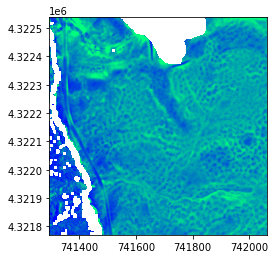

In [6]:
# Grab a session
engine, session = get_db(db_name)

# Remember in the query parentheses is what we get back, in this case were asking for the raster data as a geotiff
result = session.query(func.ST_AsTiff(ImageData.raster)).filter(ImageData.type == 'depth').limit(1).all()

# Now make it more available as a python object 
datasets = raster_to_rasterio(session, result)

# Plot the georeferenced image 
show(datasets[0], vmax=1.2, vmin=0, cmap='winter')

# Close the dataset
datasets[0].close()
session.close()

### Lets use a few more. 

Lets try to get a raster tile on a pit!

Checkout the documentation for 

* [`ST_Union`](https://postgis.net/docs/RT_ST_Union.html)
* [`ST_Intersects`](https://postgis.net/docs/RT_ST_Intersects.html)


/tmp/ipykernel_641/1668136670.py:15: SAWarning: UserDefinedType Geometry(geometry_type='POINT') will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  point = session.query(SiteData.geom).filter(SiteData.site_id == site_id).distinct().all()[0][0]
/tmp/ipykernel_641/1668136670.py:32: SAWarning: Class ST_Union will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the supercla

1


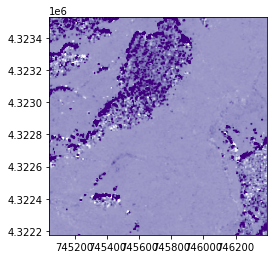

In [7]:
# import our pits metadata table class
from snowexsql.data import SiteData
from geoalchemy2.types import Raster
import geoalchemy2.functions as gfunc

# Grab a session
engine, session = get_db(db_name)

# session.rollback()

# 1. Lets choose a site we want to grab a raster tile
site_id = '5S31'

# 2. Get the location of the pit, POSTGIS functions like to work in the text format of things so convert the point geom to text which is also in binary in the db   
point = session.query(SiteData.geom).filter(SiteData.site_id == site_id).distinct().all()[0][0]

# 3. Merge all the tiles together, note gfunc vs func. This is because ST_Union exists in two places in postgis for geom and rasters!
base = gfunc.ST_Union(ImageData.raster, _type=Raster)

# 4. Get the merged result as a geotiff! 
base = func.ST_AsTiff(base)

# 5. Filter by uavsar interferogram data
qry = session.query(base).filter(ImageData.type == 'insar interferogram real')

# 6. Filter by a polarization in the description 
qry = qry.filter(ImageData.description.contains('Polarization = HH'))

# 7. Isolate tiles touching the pit location
qry = qry.filter(func.ST_Intersects(ImageData.raster, point))

print(qry.count())

# 8. Execute, convert and plot! 
result = qry.all()
datasets = raster_to_rasterio(session, result)
show(datasets[0], vmin=-0.02, vmax=0.02, cmap='Purples')

session.close()

**Discussion**

* What is a fundamental difference do you see in using `ST_Union` vs `ST_Intersects`
* Did you notice `ST_Union` used `gfunc.` instead of `func.` ? How many `ST_Union`'s exist? 


* [`RT_ST_Union`](https://postgis.net/docs/RT_ST_Union.html)
* [`ST_Union`](https://postgis.net/docs/ST_Union.html)

### Lets work with some points and Postgis
These functions are critical to rasters use with the database. But there are plenty of very useful functions for non-raster data too! A common use is to grab points in a certain geometry of a locations like a pit.

Lets pick a pit and grab data with a certain radius of that pit using postgis functions.

Checkout the documentation on:

[`ST_Buffer`](https://postgis.net/docs/ST_Buffer.html)


/tmp/ipykernel_641/3893088721.py:22: SAWarning: UserDefinedType Geometry(geometry_type='POINT') will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  site_geom = qry.all()[0][0]
/tmp/ipykernel_641/3893088721.py:28: SAWarning: Class ST_Buffer will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will d

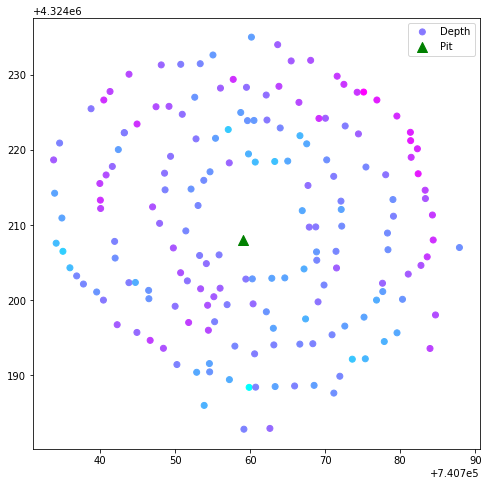

In [8]:
from snowexsql.data import PointData
from snowexsql.conversions import query_to_geopandas
import matplotlib.pyplot as plt 


# Pick a pit ID
site_id = '1N3'

# Pick a distance around the pit to collect data in meters
buffer_dist = 50

# Grab a session
engine, session = get_db(db_name)

# Grab our pit location by provided site id from the site details table
qry = session.query(SiteData.geom).filter(SiteData.site_id == site_id)

# convert qry to df for easy plotting 
site_df = query_to_geopandas(qry, engine)

# Also execute it for the normal db usage
site_geom = qry.all()[0][0]

# Create a polygon buffered by our distance centered on the pit
qry = session.query(func.ST_Buffer(site_geom, buffer_dist))

# Execute for other querying
buffered_pit = qry.all()[0][0]

# Filter by the dataset type depth
qry = session.query(PointData).filter(PointData.type == 'depth').filter(PointData.instrument.in_(['magnaprobe','mesa']))

# Grab all the point data in the buffer
qry = qry.filter(func.ST_Within(PointData.geom, buffered_pit))
df = query_to_geopandas(qry, engine)

session.close()

# plot it with style!
fig, ax = plt.subplots(figsize=(8,8))
ax = df.plot(ax=ax, column='value', cmap='cool')
site_df.plot(ax=ax, marker='^', markersize=100, color='green')
ax.legend(["Depth", "Pit"])


## Recap

Postgis functions are awesome but can be finicky. So go slow with them.

**You should know**
* Where to find PostGIS functions 
* When to use geoalchemy2 over sqlachemy functions call 
* How to chain together commands 